In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from pathlib import Path
import matplotlib.pyplot as plt

## Load Data

In [2]:
MATRES_DATA_PATH = Path('../data') / 'MATRES'

In [3]:
aquaint_df = pd.read_csv(MATRES_DATA_PATH / 'aquaint.txt', sep='\t', header=None,
                         names=['docid', 'verb1', 'verb2', 'eiid1', 'eiid2', 'relation'])

In [4]:
platinum_df = pd.read_csv(MATRES_DATA_PATH / 'platinum.txt', sep='\t', header=None,
                         names=['docid', 'verb1', 'verb2', 'eiid1', 'eiid2', 'relation'])

In [5]:
timebank_df = pd.read_csv(MATRES_DATA_PATH / 'timebank.txt', sep='\t', header=None,
                         names=['docid', 'verb1', 'verb2', 'eiid1', 'eiid2', 'relation'])

## Prepare Graphs

### Utils

In [6]:
from functools import reduce

supported_relation = ['AFTER', 'BEFORE']

def create_edges(df):
    edges_df = pd.DataFrame()
    edges_df[['source', 'target']] = df[['docid', 'eiid1', 'eiid2', 'relation']] \
        .apply(lambda row: (f"{row.docid}-{row['eiid2']}" ,f"{row.docid}-{row['eiid1']}")
                if row['relation'] == 'AFTER' else (f"{row.docid}-{row['eiid1']}" , f"{row.docid}-{row['eiid2']}"),
               axis='columns', result_type="expand")
    return edges_df

def create_nodes(df):
    nodes_raw_df = df.apply(lambda row: [dict(docid=row.docid, verb=row.verb1, eiid=f"{row.docid}-{row.eiid1}"),
                                  dict(docid=row.docid, verb=row.verb2, eiid=f"{row.docid}-{row.eiid2}")], axis='columns').to_list()
    nodes_flatten = reduce(lambda x, y: x+y, nodes_raw_df)
    return pd.DataFrame(nodes_flatten).drop_duplicates(ignore_index=True)

def generate_directed_graph(df, relations=supported_relation):
    df = df.loc[df['relation'].isin(relations)]
    edges = create_edges(df)
    nodes = create_nodes(df)

    G = nx.from_pandas_edgelist(edges, create_using=nx.DiGraph)
    nx.set_node_attributes(G, dict(zip(nodes.eiid, nodes.docid)), 'docid')
    nx.set_node_attributes(G, dict(zip(nodes.eiid, nodes.verb)), 'verb')
    return G

def generate_subgraph_by_docid(graph, doc_id):
    sub_graph = []
    for (n, data) in graph.nodes(data=True):
      if data['docid'] == doc_id:
        sub_graph.append(n)

    return graph.subgraph(sub_graph).copy()

In [7]:
def draw_directed_graph(graph, custom_layout=None):
    plt.rcParams["figure.figsize"] = (15,10)

    labels = nx.get_node_attributes(graph, 'verb')
    if custom_layout is None:
        pos = nx.circular_layout(graph)
    else:
        pos = custom_layout(graph)

    nx.draw_networkx_nodes(graph, pos)
    nx.draw_networkx_labels(graph, pos, labels=labels)
    nx.draw_networkx_edges(
        graph,
        pos,
        arrows=True,
        edgelist=graph.edges(),
        edge_color='blue',
        width=3,
        label="S",
        arrowstyle='-|>')

    # plt.legend(fontsize = 'medium')
    plt.show()

In [66]:
from itertools import chain, product, starmap
from functools import partial

def create_simple_graph(graph):

    # find connected components
    conn_components = nx.connected_components(graph.to_undirected())

    simple_edges = []
    for nodes in conn_components:
        # create copy of DiGraph
        sub_shallow = graph.subgraph(nodes).copy()

        if len(sub_shallow.edges) <= 2:
            simple_edges.extend([edge for edge in sub_shallow.edges])
            continue

        new_graph = nx.DiGraph()
        new_graph.add_nodes_from(sub_shallow.nodes(data=True))
        new_graph.add_edges_from(sub_shallow.edges)

        # find simple paths
        chaini = chain.from_iterable
        roots = (v for v, d in new_graph.in_degree() if d == 0)
        leaves = (v for v, d in new_graph.out_degree() if d == 0)

        all_paths = partial(nx.all_simple_paths, new_graph)
        all_simple_paths = chaini(starmap(all_paths, product(roots, leaves)))

        # remove redundant paths
        sorted_path = sorted(all_simple_paths, key=lambda x: -len(x))
        max_path = set(sorted_path[0])

        simple_edges.append(sorted_path[0])
        for path in sorted_path[1:]:
            if len(max_path | set(path)) > len(max_path):
                max_path.update(path)
                simple_edges.append(path)

    simple_graph = nx.DiGraph()
    simple_graph.add_nodes_from(graph.nodes(data=True))

    for path in simple_edges:
        nx.add_path(simple_graph, path)

    return simple_graph, simple_edges

### Prepare Sample Graph With Simple Paths

#### Simple Case

In [49]:
aquaint_df[(aquaint_df.docid == 'XIE19990227.0171') & (aquaint_df.relation.isin(supported_relation))]

,docid,verb1,verb2,eiid1,eiid2,relation
750,XIE19990227.0171,were,invited,6,8,AFTER
751,XIE19990227.0171,were,join,6,10,BEFORE
752,XIE19990227.0171,invited,join,8,10,BEFORE
753,XIE19990227.0171,invited,signed,8,12,BEFORE
754,XIE19990227.0171,join,signed,10,12,AFTER
755,XIE19990227.0171,signed,invited,12,13,BEFORE
756,XIE19990227.0171,invited,travel,13,15,BEFORE


In [50]:
sample_graph = generate_directed_graph(df=aquaint_df[aquaint_df.docid == 'XIE19990227.0171'])

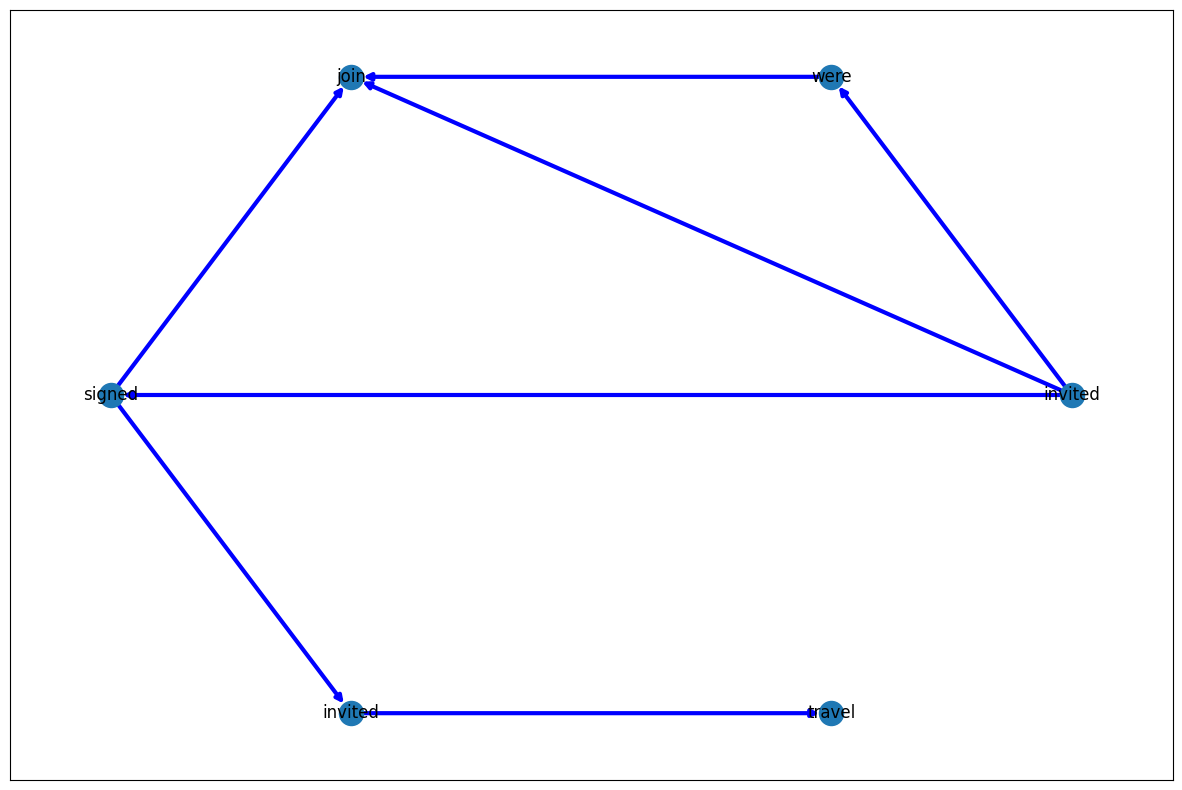

In [51]:
draw_directed_graph(sample_graph)

In [67]:
simple_k, simple_k_edges = create_simple_graph(graph=sample_graph)

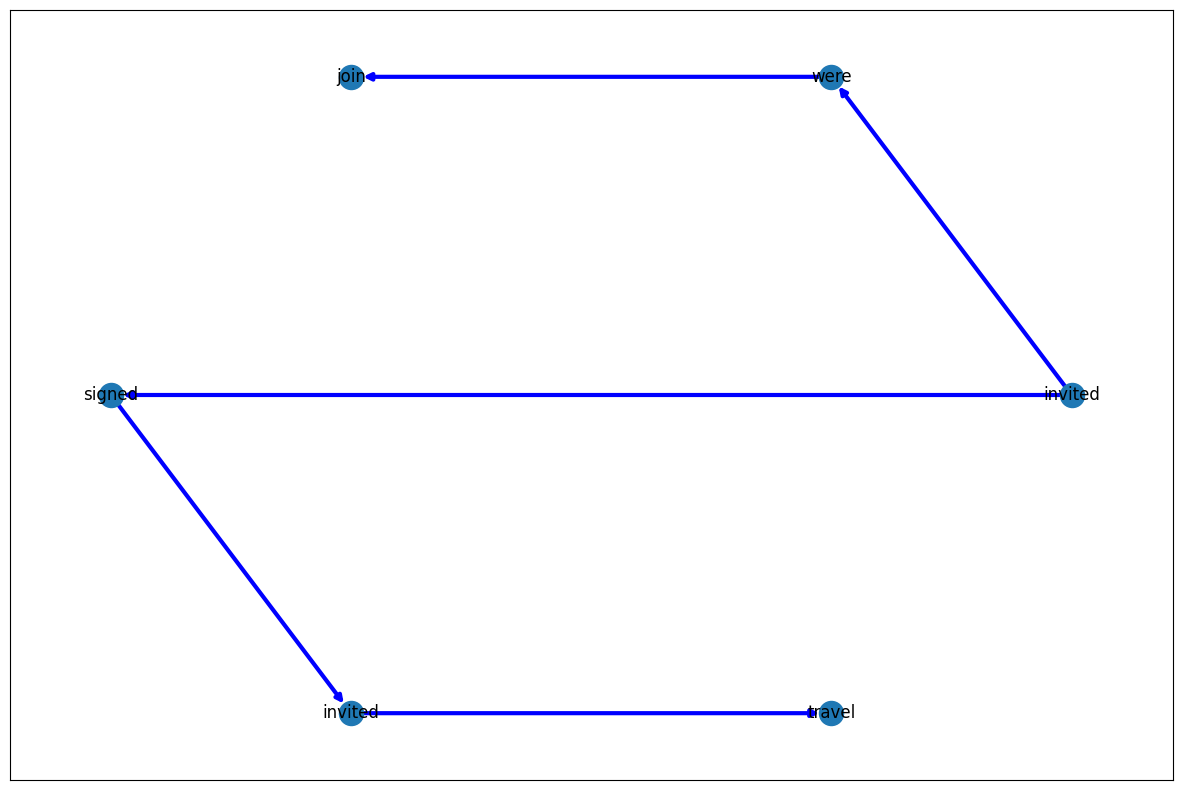

In [68]:
draw_directed_graph(simple_k)

In [15]:
mapping_k = {n: d['verb'] for n, d in sample_graph.nodes(data=True)}

In [16]:
[[mapping_k[p] for p in lp] for lp in simple_k_edges]

[['invited', 'were', 'join', 'signed', 'invited', 'travel']]

#### Biggest Case

In [41]:
biggest_df = aquaint_df[(aquaint_df.docid == 'NYT19990312.0271') & (aquaint_df.relation.isin(supported_relation))]
biggest_df

,docid,verb1,verb2,eiid1,eiid2,relation
2260,NYT19990312.0271,embraced,ending,1,2,BEFORE
2261,NYT19990312.0271,embraced,began,1,4,AFTER
2262,NYT19990312.0271,embraced,opening,1,6,BEFORE
2263,NYT19990312.0271,ending,began,2,4,AFTER
2264,NYT19990312.0271,ending,opening,2,6,BEFORE
...,...,...,...,...,...,...
2631,NYT19990312.0271,live,created,206,208,BEFORE
2633,NYT19990312.0271,created,gone,208,212,BEFORE
2634,NYT19990312.0271,been,gone,210,212,BEFORE
2635,NYT19990312.0271,been,said,210,216,BEFORE


In [42]:
biggest_graph = generate_directed_graph(df=aquaint_df[aquaint_df.docid == 'NYT19990312.0271'])

In [36]:
simple_k, simple_k_edges = create_simple_graph(graph=biggest_graph)

In [39]:
type(simple_k)

networkx.classes.digraph.DiGraph

In [48]:
biggest_graph_cycles = list(nx.simple_cycles(biggest_graph))
biggest_graph_cycles

[]

In [47]:
print('num of cycles in directed graph:', len(biggest_graph_cycles), 'example of cycle:', biggest_graph_cycles[0])

IndexError: list index out of range

In [33]:
eiids = [int(n_id.split('-')[1]) for n_id in biggest_graph_cycles[0]]
eiids

[47, 52, 45]

In [34]:
biggest_df[(biggest_df.eiid1.isin(eiids)) & (biggest_df.eiid2.isin(eiids))]

,docid,verb1,verb2,eiid1,eiid2,relation
2352,NYT19990312.0271,moved,sat,45,47,BEFORE
2356,NYT19990312.0271,moved,do,45,52,BEFORE
2360,NYT19990312.0271,sat,do,47,52,AFTER


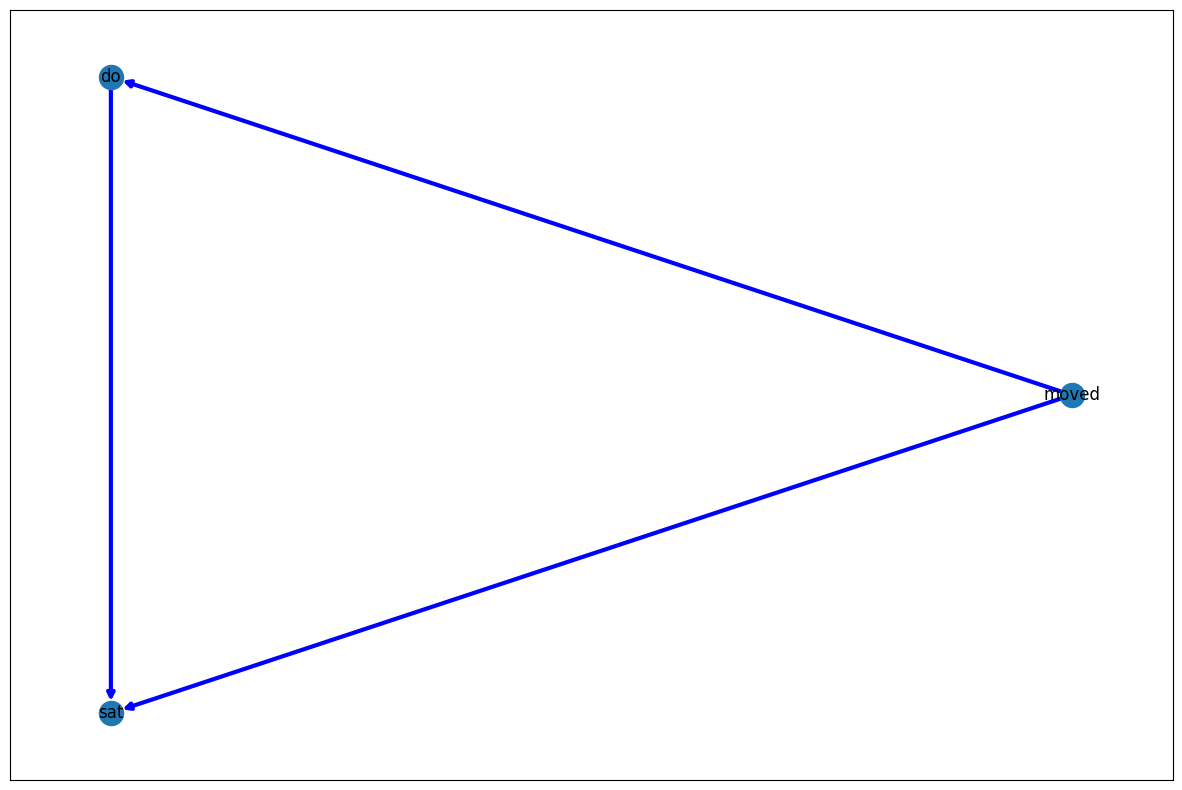

In [20]:
draw_directed_graph(biggest_graph.subgraph(biggest_graph_cycles[0]))

In [55]:
from dash import Dash, html
import dash_cytoscape as cyto

def generate_dash(graph):
    app = Dash(__name__)

    nodes = [{'data': {'id': _id, 'label': d['verb']}}  for _id, d in graph.nodes(data=True)]
    edges = [{'data': {'source': source, 'target': target}} for source, target in graph.edges]

    app.layout = html.Div([
        cyto.Cytoscape(
            id='cytoscape',
            elements=nodes + edges,
            layout={'name': 'breadthfirst'},
            style={'width': '4000px', 'height': '5000px'}
        )
    ])


    app.run_server(debug=True, use_reloader=False)

In [48]:
simple_k, simple_k_edges = create_simple_graph(graph=biggest_graph)

In [59]:
import gravis as gv

fig = gv.d3(biggest_graph)
fig.display(inline=False)

In [63]:
fig2 = gv.d3(simple_k, node_label_data_source='verb')
fig2.display(inline=False)